# Text Embedding Notebook

### 1) First, the imports

In [1]:
import pandas as pd
import numpy as np
import os
import re
import glob
import json
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

C:\Users\Kiki\anaconda3\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### 2) Then, read the data

In [2]:
# Specify the path to the folder containing the .md files
folder_path = 'sagemaker_documentation'

# Use glob to find all .md files in the specified folder
md_files = glob.glob(os.path.join(folder_path, '*.md'))

# Create an empty list to store the data
data = []

# Read the contents of each .md file and store in the list
for file in md_files:
    with open(file, 'r', encoding='utf-8') as f:
        content = f.read()
        doc_name = os.path.splitext(os.path.basename(file))[0]  
        data.append({'id': doc_name, 'text': content})

# Convert the list to a DataFrame
df = pd.DataFrame(data)

### 3) Check the length of all documents (prior preprocessing for orientation)

In [3]:
# Get a list of the length of every document in our
# document repository 

lens=[]
for index, row in df.iterrows():
    #print(len(row['text'].split(" ")))
    lens.append(len(row['text'].split(" ")))

It's obvious when visualizing the document length, majority of documents fall within the 0-200 tokens category. There are very few longer documents and even few that behave as outliers (> 4k tokens length).

Of course, the actual number of tokens can be reduced after preprocessing, but this gives a good idea on what kind of an embedding model can be used.

Text(0.5, 1.0, 'Boxplot')

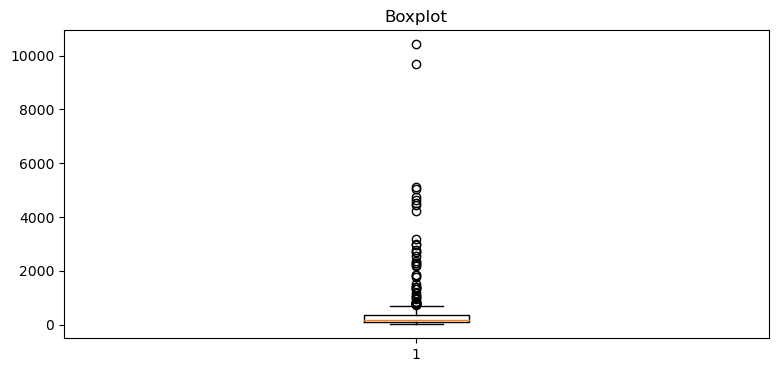

In [4]:
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.boxplot(lens)
plt.title('Boxplot')

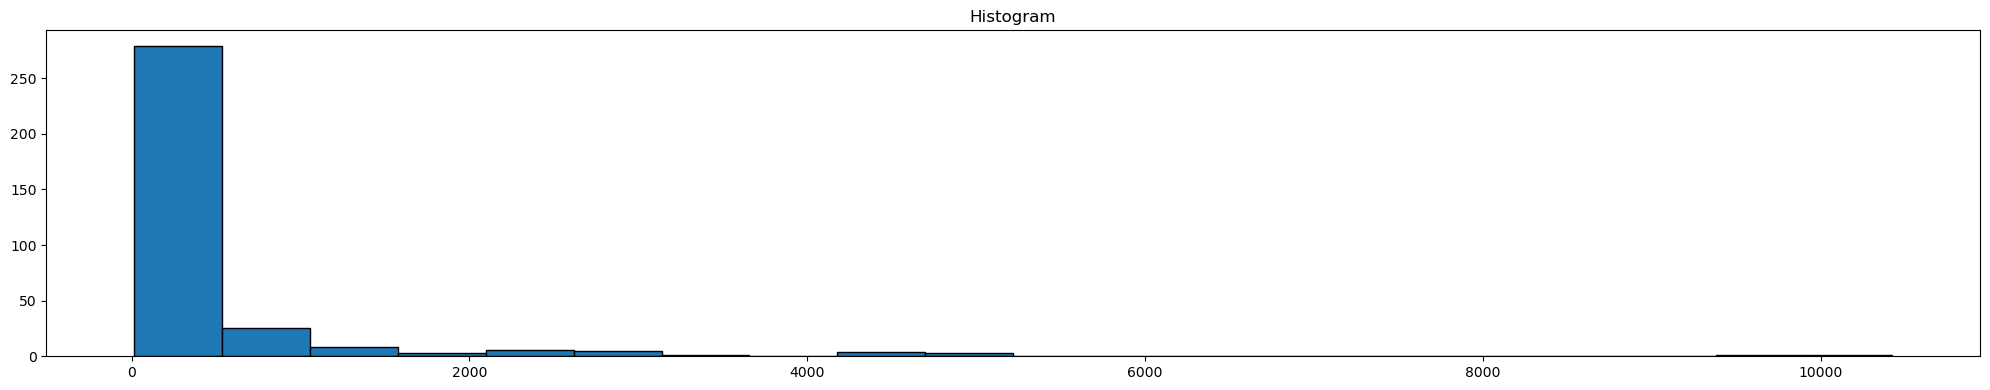

In [5]:
# Generate a histogram
plt.figure(figsize=(20, 4))

plt.hist(lens, bins=20, edgecolor='black')
plt.title('Histogram')

# Show plots
plt.tight_layout()
plt.show()

In [6]:
np.mean(lens), max(lens), np.median(lens)

(494.3452380952381, 10421, 162.0)

#### -> We can choose an embedding model which supports smaller sequence length and split only the documents that exceed the max length

### 4) Select an Embedding Model from HuggingFace

#### https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

From docs: This is a sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.

In [7]:
# SentenceTransformer wrapper function to get the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

C:\Users\Kiki\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
# Test if it works
sentences = ["This is an example sentence", "Each sentence is converted"]
embeddings = model.encode(sentences)
print(embeddings)

[[ 6.76569417e-02  6.34959564e-02  4.87131029e-02  7.93048963e-02
   3.74480709e-02  2.65277619e-03  3.93749177e-02 -7.09846616e-03
   5.93614057e-02  3.15370224e-02  6.00980818e-02 -5.29052354e-02
   4.06067409e-02 -2.59308442e-02  2.98428535e-02  1.12691487e-03
   7.35148937e-02 -5.03818579e-02 -1.22386597e-01  2.37028375e-02
   2.97265276e-02  4.24768776e-02  2.56337691e-02  1.99514348e-03
  -5.69190495e-02 -2.71597989e-02 -3.29035297e-02  6.60248995e-02
   1.19007193e-01 -4.58791330e-02 -7.26214200e-02 -3.25840116e-02
   5.23414016e-02  4.50553410e-02  8.25305004e-03  3.67024243e-02
  -1.39415674e-02  6.53918684e-02 -2.64272075e-02  2.06393175e-04
  -1.36643527e-02 -3.62811014e-02 -1.95043907e-02 -2.89738420e-02
   3.94270532e-02 -8.84090662e-02  2.62423488e-03  1.36713171e-02
   4.83062454e-02 -3.11566181e-02 -1.17329188e-01 -5.11690676e-02
  -8.85287672e-02 -2.18963325e-02  1.42986281e-02  4.44167778e-02
  -1.34816021e-02  7.43392631e-02  2.66382936e-02 -1.98762678e-02
   1.79191

#### We will use the model only for text embeddings and we'll omit the images in the data. 

9 out of 336 .md files contain an image which is 2.67% of the dataset. Wasting additional resources to adapt a multimodal model to output images as well will not bring much additional value.

### 5) Preprocess Text

In [9]:
def remove_html_anchors(text):
    """
    Remove HTML anchor tags from 
    the markdown content.
    """
    return re.sub(r'<a name="[^>]+"></a>', '', text)

In [10]:
df.head()

,id,text
0,amazon-sagemaker-toolkits,# Using the SageMaker Training and Inference T...
1,asff-resourcedetails-awssagemaker,"# AwsSageMaker<a name=""asff-resourcedetails-aw..."
2,automating-sagemaker-with-eventbridge,# Automating Amazon SageMaker with Amazon Even...
3,aws-properties-events-rule-sagemakerpipelinepa...,# AWS::Events::Rule SageMakerPipelineParameter...
4,aws-properties-events-rule-sagemakerpipelinepa...,# AWS::Events::Rule SageMakerPipelineParameter...


In [11]:
html_removed_texts = []
for index, row in df.iterrows():
    # Adding both the doc if and the preprocessed text
    html_removed_texts.append((row['id'], remove_html_anchors(row['text'])))

In [12]:
def normalize_text(text):
    """
    Convert text to lowercase and 
    replace special characters.
    """
    text = text.lower()
    text = re.sub(r'\\\.', '.', text)
    text = re.sub(r'\\\(', '(', text)
    text = re.sub(r'\\\)', ')', text)
    return text

In [13]:
normalized_texts = []
for i in range(0, len(html_removed_texts)):
    normalized_texts.append((html_removed_texts[i][0], normalize_text(html_removed_texts[i][1])))

In [14]:
def split_text_by_tokens(text, max_tokens=256):
    tokens = text.split()
    
    # Initialize variables
    chunks = []
    current_chunk = []
    
    for token in tokens:
        # If adding this token exceeds the limit, save the current chunk and start a new one
        if len(current_chunk) + 1 > max_tokens:
            chunks.append(' '.join(current_chunk))
            current_chunk = [token]
        else:
            current_chunk.append(token)
    
    # Add the last chunk if there's remaining content
    if current_chunk:
        chunks.append(' '.join(current_chunk))
    
    return chunks

In [15]:
chunk_texts = []
transformed_df = pd.DataFrame(columns=['doc_id', 'text'])

In [16]:
for i in range(0, len(normalized_texts)):
    chunks = split_text_by_tokens(normalized_texts[i][1])
    for chunk in chunks:
        transformed_df = transformed_df.append({'doc_id': normalized_texts[i][0], 'text': chunk}, ignore_index=True)
        
transformed_df.insert(0, 'id', range(0, 0 + len(transformed_df)))

C:\Users\Kiki\AppData\Local\Temp\ipykernel_2436\419759795.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transformed_df = transformed_df.append({'doc_id': normalized_texts[i][0], 'text': chunk}, ignore_index=True)
C:\Users\Kiki\AppData\Local\Temp\ipykernel_2436\419759795.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transformed_df = transformed_df.append({'doc_id': normalized_texts[i][0], 'text': chunk}, ignore_index=True)
C:\Users\Kiki\AppData\Local\Temp\ipykernel_2436\419759795.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transformed_df = transformed_df.append({'doc_id': normalized_texts[i][0], 'text': chunk}, ignore_index=True)
C:\Users\Kiki\AppData\Local\Temp\ipykernel_2436\419759795.py:4: FutureWarnin

C:\Users\Kiki\AppData\Local\Temp\ipykernel_2436\419759795.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transformed_df = transformed_df.append({'doc_id': normalized_texts[i][0], 'text': chunk}, ignore_index=True)
C:\Users\Kiki\AppData\Local\Temp\ipykernel_2436\419759795.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transformed_df = transformed_df.append({'doc_id': normalized_texts[i][0], 'text': chunk}, ignore_index=True)
C:\Users\Kiki\AppData\Local\Temp\ipykernel_2436\419759795.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transformed_df = transformed_df.append({'doc_id': normalized_texts[i][0], 'text': chunk}, ignore_index=True)
C:\Users\Kiki\AppData\Local\Temp\ipykernel_2436\419759795.py:4: FutureWarnin

C:\Users\Kiki\AppData\Local\Temp\ipykernel_2436\419759795.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transformed_df = transformed_df.append({'doc_id': normalized_texts[i][0], 'text': chunk}, ignore_index=True)
C:\Users\Kiki\AppData\Local\Temp\ipykernel_2436\419759795.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transformed_df = transformed_df.append({'doc_id': normalized_texts[i][0], 'text': chunk}, ignore_index=True)
C:\Users\Kiki\AppData\Local\Temp\ipykernel_2436\419759795.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transformed_df = transformed_df.append({'doc_id': normalized_texts[i][0], 'text': chunk}, ignore_index=True)
C:\Users\Kiki\AppData\Local\Temp\ipykernel_2436\419759795.py:4: FutureWarnin

In [19]:
transformed_df.head()

,id,doc_id,text
0,0,amazon-sagemaker-toolkits,# using the sagemaker training and inference t...
1,1,amazon-sagemaker-toolkits,"information, see [use your own training algori..."
2,2,amazon-sagemaker-toolkits,how to create sagemaker containers and how scr...
3,3,asff-resourcedetails-awssagemaker,# awssagemaker the following are examples of t...
4,4,automating-sagemaker-with-eventbridge,# automating amazon sagemaker with amazon even...


### 6) Encode text

In [20]:
encoded_texts = []

for index, row in transformed_df.iterrows():
    encoded_texts.append(model.encode(row['text']))

In [24]:
len(encoded_texts) == len(transformed_df)

True

In [25]:
transformed_df['embeddings'] = encoded_texts

In [26]:
transformed_df

,id,doc_id,text,embeddings
0,0,amazon-sagemaker-toolkits,# using the sagemaker training and inference t...,"[-0.055574704, -0.07746529, -0.06579108, 0.028..."
1,1,amazon-sagemaker-toolkits,"information, see [use your own training algori...","[-0.055655003, -0.08578733, -0.049293544, 0.05..."
2,2,amazon-sagemaker-toolkits,how to create sagemaker containers and how scr...,"[-0.046100687, -0.039258875, -0.07864068, 0.02..."
3,3,asff-resourcedetails-awssagemaker,# awssagemaker the following are examples of t...,"[-0.052956294, 0.071878634, -0.09741248, 0.027..."
4,4,automating-sagemaker-with-eventbridge,# automating amazon sagemaker with amazon even...,"[-0.059120536, -0.052780572, -0.038032, 0.0297..."
...,...,...,...,...
604,604,train-evaluate-models-using-sagemaker-notebook,"console. in particular, you can watch the eval...","[0.023031384, -0.019438444, -0.0897, -0.014899..."
605,605,use-sagemaker-edge-manager,# use amazon sagemaker edge manager on greengr...,"[-0.075721614, -0.04767376, -0.004293286, -0.0..."
606,606,use-sagemaker-edge-manager,sagemaker neo\-compiled models using sagemaker...,"[-0.07614313, -0.05914641, -0.02349067, 0.0538..."
607,607,use-sagemaker-edge-manager,"data with sagemaker edge manager, see [manage ...","[-0.045925807, -0.07032738, -0.04972807, 0.023..."


In [30]:
len(encoded_texts[5])

384

In [31]:
def cosine_similarity(vec1, vec2):
    """
    Calculate the cosine similarity between two vector embeddings.

    Parameters:
    - vec1: A numpy array representing the first vector embedding.
    - vec2: A numpy array representing the second vector embedding.

    Returns:
    - Cosine similarity: A float value between -1 and 1.
    """
    # Ensure the vectors are numpy arrays
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)

    # Compute the dot product between the two vectors
    dot_product = np.dot(vec1, vec2)

    # Compute the L2 norms (magnitudes) of the vectors
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)

    # Calculate the cosine similarity
    cosine_sim = dot_product / (norm_vec1 * norm_vec2)

    return cosine_sim

Sanity check: chunks of texts that belong to the same document have a higher cosine similarity.

In [32]:
cosine_similarity(encoded_texts[0], encoded_texts[2])

0.81522477

In [33]:
cosine_similarity(encoded_texts[0], encoded_texts[3])

0.39343607

In [34]:
cosine_similarity(encoded_texts[1], encoded_texts[3])

0.25215968

In [35]:
cosine_similarity(encoded_texts[31], encoded_texts[30])

0.8127693

### 7) Save embeddings table

In [36]:
transformed_df.to_csv("text_with_embeddings.csv", index=False)